![ML](https://raw.githubusercontent.com/AniMilina/Parkinson-s-Freezing-of-Gait-Prediction/main/EDA.jpg)


Our task is to detect freezing of gait (FOG) episodes during walking in the tdcsfog and defog datasets. To accomplish this, we need to use the data of temporal steps, accelerations along three axes, and event types (recorded in the Type column) from these two datasets.

The defog dataset has two additional columns: Valid and Task. We should only use event annotations where the series is marked as true, and sections marked as false should be treated as unannotated.

The tdcsfog_metadata, defog_metadata, and events metadata contain information about laboratory visits, tests performed, and medications taken for each subject in the study. We can use this information to analyze the results of our model depending on various factors.

In [1]:
import pandas as pd
import numpy as np
import os
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mutual_info_score
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Set formatting option

pd.options.display.float_format = '{:.3f}'.format

In [3]:
def fill_missing_values(df):
    """
    Replaces missing values with the median value for each numerical column.

    :param df: pandas DataFrame, the dataset in which missing values need to be replaced
    :return: pandas DataFrame, the dataset with replaced missing values
    """
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns  # Selecting all numerical columns
    for col in numeric_cols:
        median = df[col].median()  # Finding the Median Value of a Column
        df[col].fillna(median, inplace=True)   # Replacing Missing Values with the Median Value
    return df

In [4]:
# Function to Get Data Information

def explore_dataframe(df):
    print("Shape of dataframe:", df.shape)
    display(df.head())
    print("Info of dataframe:\n")
    df.info()
    print("Summary statistics of dataframe:\n", df.describe())
    print("Missing values in dataframe:\n", df.isnull().sum())
    print("Duplicate rows in dataframe:", df.duplicated().sum())

In [5]:
# Checking for Missing Values in Each Column

def check_missing_values(df):
    """
    Checks the count of missing values in each column of a DataFrame.

    :param df: pandas.DataFrame, the DataFrame to check for missing values.
    :return: pandas.DataFrame, the DataFrame with information about missing values.
    """
    return df.isnull().sum()

In [6]:
# Reading Data from tdcsfog_metadata.csv

tdcsfog = pd.read_csv('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/tdcsfog_metadata.csv')

# Reading Data from defog_metadata.csv

defog = pd.read_csv('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/defog_metadata.csv')

# Reading Data from events.csv

events = pd.read_csv('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/events.csv')

# Reading Data from train & tdcsfog & daily_metadata.csv

acc = pd.read_csv('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/tdcsfog/08fbe142f9.csv')

# Reading Data from subjects.csv

subject = pd.read_csv('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/subjects.csv')

In [7]:
explore_dataframe(tdcsfog)

Shape of dataframe: (833, 5)


,Id,Subject,Visit,Test,Medication
0,003f117e14,4dc2f8,3,2,on
1,009ee11563,f62eec,4,2,on
2,011322847a,231c3b,2,2,on
3,01d0fe7266,231c3b,2,1,off
4,024418ba39,fa8764,19,3,on


Info of dataframe:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 833 entries, 0 to 832
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Id          833 non-null    object
 1   Subject     833 non-null    object
 2   Visit       833 non-null    int64 
 3   Test        833 non-null    int64 
 4   Medication  833 non-null    object
dtypes: int64(2), object(3)
memory usage: 32.7+ KB
Summary statistics of dataframe:
         Visit    Test
count 833.000 833.000
mean    6.461   1.975
std     6.172   0.813
min     2.000   1.000
25%     2.000   1.000
50%     4.000   2.000
75%     5.000   3.000
max    20.000   3.000
Missing values in dataframe:
 Id            0
Subject       0
Visit         0
Test          0
Medication    0
dtype: int64
Duplicate rows in dataframe: 0


The dataset appears to be complete and clean, with no missing values or duplicates.

The dataset consists of 833 records and 5 columns, which describe the patient identifier, visit number, test number, medication treatment, and test results. The "Test" column has only three possible values, indicating that each test measured only one parameter. These attributes provide valuable information for analysis and model building.

In [8]:
explore_dataframe(defog)

Shape of dataframe: (137, 4)


,Id,Subject,Visit,Medication
0,02ab235146,e1f62e,2,on
1,02ea782681,ae2d35,2,on
2,06414383cf,8c1f5e,2,off
3,092b4c1819,2874c5,1,off
4,0a900ed8a2,0e3d49,2,on


Info of dataframe:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Id          137 non-null    object
 1   Subject     137 non-null    object
 2   Visit       137 non-null    int64 
 3   Medication  137 non-null    object
dtypes: int64(1), object(3)
memory usage: 4.4+ KB
Summary statistics of dataframe:
         Visit
count 137.000
mean    1.489
std     0.502
min     1.000
25%     1.000
50%     1.000
75%     2.000
max     2.000
Missing values in dataframe:
 Id            0
Subject       0
Visit         0
Medication    0
dtype: int64
Duplicate rows in dataframe: 0


This dataset contains information about 137 patients who underwent treatment with various medications to improve brain function.

Each row provides information about the patient's identifier, their FOG identifier, and whether or not they took medication.

The dataset does not contain any missing values or duplicates.

Among the patients, there are only two values for the visit number: 1 and 2. The majority of patients (75%) underwent treatment during the first visit.

In [9]:
explore_dataframe(events)

Shape of dataframe: (3544, 5)


,Id,Init,Completion,Type,Kinetic
0,003f117e14,8.613,14.773,Turn,1.000
1,009ee11563,11.385,41.185,Turn,1.000
2,009ee11563,54.665,58.785,Turn,1.000
3,011322847a,28.097,30.297,Turn,1.000
4,01d0fe7266,30.318,31.878,Turn,1.000


Info of dataframe:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3544 entries, 0 to 3543
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Id          3544 non-null   object 
 1   Init        3544 non-null   float64
 2   Completion  3544 non-null   float64
 3   Type        2502 non-null   object 
 4   Kinetic     2502 non-null   float64
dtypes: float64(3), object(2)
memory usage: 138.6+ KB
Summary statistics of dataframe:
           Init  Completion  Kinetic
count 3544.000    3544.000 2502.000
mean   956.298     964.489    0.818
std    946.357     943.969    0.386
min    -30.669     -29.719    0.000
25%     39.518      48.611    1.000
50%    768.657     774.261    1.000
75%   1570.300    1576.697    1.000
max   4381.217    4392.745    1.000
Missing values in dataframe:
 Id               0
Init             0
Completion       0
Type          1042
Kinetic       1042
dtype: int64
Duplicate rows in dataframe: 0


The dataset consists of 3544 events, each characterized by five columns: "Id", "Init", "Completion", "Type", and "Kinetic". "Id" represents a unique identifier for each event. "Init" and "Completion" describe the start and end time of the event, respectively. "Type" and "Kinetic" are categorical and numerical variables, respectively, that describe the type and kinetic activity of the event.

The number of non-null values for all columns is 3544, except for the "Type" and "Kinetic" columns, which have 1042 missing values. There are no duplicate rows in the dataset.

The mean values for "Init", "Completion", and "Kinetic" are 956.30, 964.49, and 0.82, respectively. The standard deviations are 946.36, 943.97, and 0.39, respectively. The minimum and maximum values for "Init" are -30.67 and 4381.22, respectively, while for "Completion", the minimum and maximum values are -29.72 and 4392.75, respectively.

In [10]:
explore_dataframe(acc)

Shape of dataframe: (4474, 7)


,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking
0,0,-9.777,0.110,-0.537,0,0,0
1,1,-9.788,0.090,-0.525,0,0,0
2,2,-9.788,0.074,-0.544,0,0,0
3,3,-9.777,0.117,-0.548,0,0,0
4,4,-9.786,0.119,-0.537,0,0,0


Info of dataframe:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4474 entries, 0 to 4473
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Time             4474 non-null   int64  
 1   AccV             4474 non-null   float64
 2   AccML            4474 non-null   float64
 3   AccAP            4474 non-null   float64
 4   StartHesitation  4474 non-null   int64  
 5   Turn             4474 non-null   int64  
 6   Walking          4474 non-null   int64  
dtypes: float64(3), int64(4)
memory usage: 244.8 KB
Summary statistics of dataframe:
           Time     AccV    AccML    AccAP  StartHesitation     Turn  Walking
count 4474.000 4474.000 4474.000 4474.000         4474.000 4474.000 4474.000
mean  2236.500   -9.615    0.136    1.138            0.000    0.000    0.000
std   1291.677    1.457    1.329    1.783            0.000    0.000    0.000
min      0.000  -20.580   -6.943  -18.379            0.000    0.00


The dataset contains 4474 rows and 7 columns: Time, AccV, AccML, AccAP, StartHesitation, Turn, and Walking.

The Time column represents the timestamp of the accelerometer data. AccV, AccML, and AccAP represent the acceleration values in the vertical, medio-lateral, and antero-posterior directions, respectively. StartHesitation, Turn, and Walking are binary variables indicating whether the subject is starting to walk, turning, or already walking at a given timestamp.

The summary statistics show that the mean value of vertical acceleration is -9.61 m/s², the mean value of medio-lateral acceleration is -0.14 m/s², and the mean value of antero-posterior acceleration is 1.14 m/s². There are no missing values or duplicate rows in the dataset.

In [11]:
explore_dataframe(subject)

Shape of dataframe: (173, 8)


,Subject,Visit,Age,Sex,YearsSinceDx,UPDRSIII_On,UPDRSIII_Off,NFOGQ
0,00f674,2.000,63,M,27.000,43.000,49.000,24
1,00f674,1.000,63,M,27.000,31.000,30.000,26
2,02bc69,NaN,69,M,4.000,21.000,NaN,22
3,040587,2.000,75,M,26.000,52.000,69.000,21
4,040587,1.000,75,M,26.000,47.000,75.000,24


Info of dataframe:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Subject       173 non-null    object 
 1   Visit         111 non-null    float64
 2   Age           173 non-null    int64  
 3   Sex           173 non-null    object 
 4   YearsSinceDx  173 non-null    float64
 5   UPDRSIII_On   172 non-null    float64
 6   UPDRSIII_Off  132 non-null    float64
 7   NFOGQ         173 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 10.9+ KB
Summary statistics of dataframe:
         Visit     Age  YearsSinceDx  UPDRSIII_On  UPDRSIII_Off   NFOGQ
count 111.000 173.000       173.000      172.000       132.000 173.000
mean    1.369  67.763        10.384       34.273        42.879  17.121
std     0.485   7.972         6.289       12.733        12.999   7.575
min     1.000  28.000         0.420        5.000        15.000   


This dataset contains data on 173 patients with Parkinson's disease. It has 8 columns, including patient ID, age, gender, time since diagnosis, UPDRSIII_On and UPDRSIII_Off test results, as well as NFOGQ questionnaire results. Some patients were tested more than once, which is reflected in the Visit column.

The dataset contains some missing values in the Visit, UPDRSIII_On, and UPDRSIII_Off columns, but only the Visit and UPDRSIII_Off columns have more than 20% missing values. The majority of patients are male (M), and the average age is 67.76 years. Regarding the NFOGQ column, the mean value is 17.12, and the minimum value is 0, which may indicate that some patients do not experience freezing of gait (FOG).

For our task, we will need the following columns from the remaining datasets:

In tdcsfog and defog: Medication - to analyze the impact of medications on disease symptoms.
In events: Init, Completion, Type - to analyze the timing of various tasks and their types.
In acc: AccV, AccML, AccAP - to analyze patient activity and assess their motor abilities.

In [12]:
#To prepare the datasets for merging, we will first remove the column "Kinetic" as it is not informative for our analysis

events = events.drop('Kinetic', axis=1)

In [13]:
# To create three new columns, "StartHesitation," "Turn," and "Walking," in the "events" dataset and assign them values from the "Type" column

events['StartHesitation'] = events['Type'].apply(lambda x: x == 'Start hesitation')
events['Turn'] = events['Type'].apply(lambda x: x == 'Turn')
events['Walking'] = events['Type'].apply(lambda x: x == 'Walking')

# To remove the "Type" column from the "events" dataset

events = events.drop('Type', axis=1)

In [14]:
# To convert the values in the "Turn," "Walking," and "StartHesitation" columns to integers

events['StartHesitation'] = events['StartHesitation'].astype(int)
events['Turn'] = events['Turn'].astype(int)
events['Walking'] = events['Walking'].astype(int)

In [15]:
merged_df = pd.merge(tdcsfog, defog, on=['Id', 'Subject', 'Visit', 'Medication'], how='outer')
events = events[['Id','Init','Completion','Turn', 'Walking', 'StartHesitation']]
merged_df = pd.merge(merged_df, events, on='Id', how='outer')
merged_df = pd.merge(merged_df, acc, on='StartHesitation', how='left')

In [16]:
# To merge the columns "Turn" and "Walking" into a single column

merged_df['Turn'] = merged_df['Turn_x'].fillna(merged_df['Turn_y'])
merged_df['Walking'] = merged_df['Walking_x'].fillna(merged_df['Walking_y'])

In [17]:
# To remove the unwanted columns

merged_df = merged_df.drop(['Turn_x', 'Turn_y', 'Walking_x', 'Walking_y'], axis=1)

In [18]:
print(check_missing_values(merged_df))

Id                        0
Subject                   0
Visit                     0
Test               10464699
Medication                0
Init                    435
Completion              435
StartHesitation         435
Time                    435
AccV                    435
AccML                   435
AccAP                   435
Turn                    435
Walking                 435
dtype: int64


There are missing values, but considering that the dataset is comprehensive, they are not significant.  
The "Test" column, which indicates the type of test performed, stands out. To preserve the integrity of the model's statistics, I will remove it at this stage but examine it together with the data from the "Subject" dataset.  
For the missing values in the accelerometer measurements, I will replace them with the median values, which should not distort the results given the small number of missing values compared to the total number of rows.

In [19]:
# Remove the "Test" column

merged_df = merged_df.drop('Test', axis=1)

In [20]:
merged_df = fill_missing_values(merged_df)

# Checking the result

check_missing_values(merged_df)

Id                 0
Subject            0
Visit              0
Medication         0
Init               0
Completion         0
StartHesitation    0
Time               0
AccV               0
AccML              0
AccAP              0
Turn               0
Walking            0
dtype: int64

### We have obtained a dataset based on which we will further investigate the task.

## Descriptive statistics and analysis of value distribution

I don't remove duplicates as I believe they represent different measurements, for example, of the same patient.

In [21]:
merged_df = merged_df.reindex(columns=['Id', 'Subject', 'Visit', 'Medication', 'Time','Init','Completion', 'AccV', 'AccML', 'AccAP', 'StartHesitation', 'Turn', 'Walking'])


In [22]:
explore_dataframe(merged_df)

Shape of dataframe: (15856291, 13)


,Id,Subject,Visit,Medication,Time,Init,Completion,AccV,AccML,AccAP,StartHesitation,Turn,Walking
0,003f117e14,4dc2f8,3,on,0.000,8.613,14.773,-9.777,0.110,-0.537,0.000,1.000,0.000
1,003f117e14,4dc2f8,3,on,1.000,8.613,14.773,-9.788,0.090,-0.525,0.000,1.000,0.000
2,003f117e14,4dc2f8,3,on,2.000,8.613,14.773,-9.788,0.074,-0.544,0.000,1.000,0.000
3,003f117e14,4dc2f8,3,on,3.000,8.613,14.773,-9.777,0.117,-0.548,0.000,1.000,0.000
4,003f117e14,4dc2f8,3,on,4.000,8.613,14.773,-9.786,0.119,-0.537,0.000,1.000,0.000


Info of dataframe:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15856291 entries, 0 to 15856290
Data columns (total 13 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   Subject          object 
 2   Visit            int64  
 3   Medication       object 
 4   Time             float64
 5   Init             float64
 6   Completion       float64
 7   AccV             float64
 8   AccML            float64
 9   AccAP            float64
 10  StartHesitation  float64
 11  Turn             float64
 12  Walking          float64
dtypes: float64(9), int64(1), object(3)
memory usage: 1.7+ GB
Summary statistics of dataframe:
              Visit         Time         Init   Completion         AccV  \
count 15856291.000 15856291.000 15856291.000 15856291.000 15856291.000   
mean         2.823     2236.500      956.293      964.484       -9.615   
std          3.484     1291.515      946.211      943.823        1.457   
min          1.000     

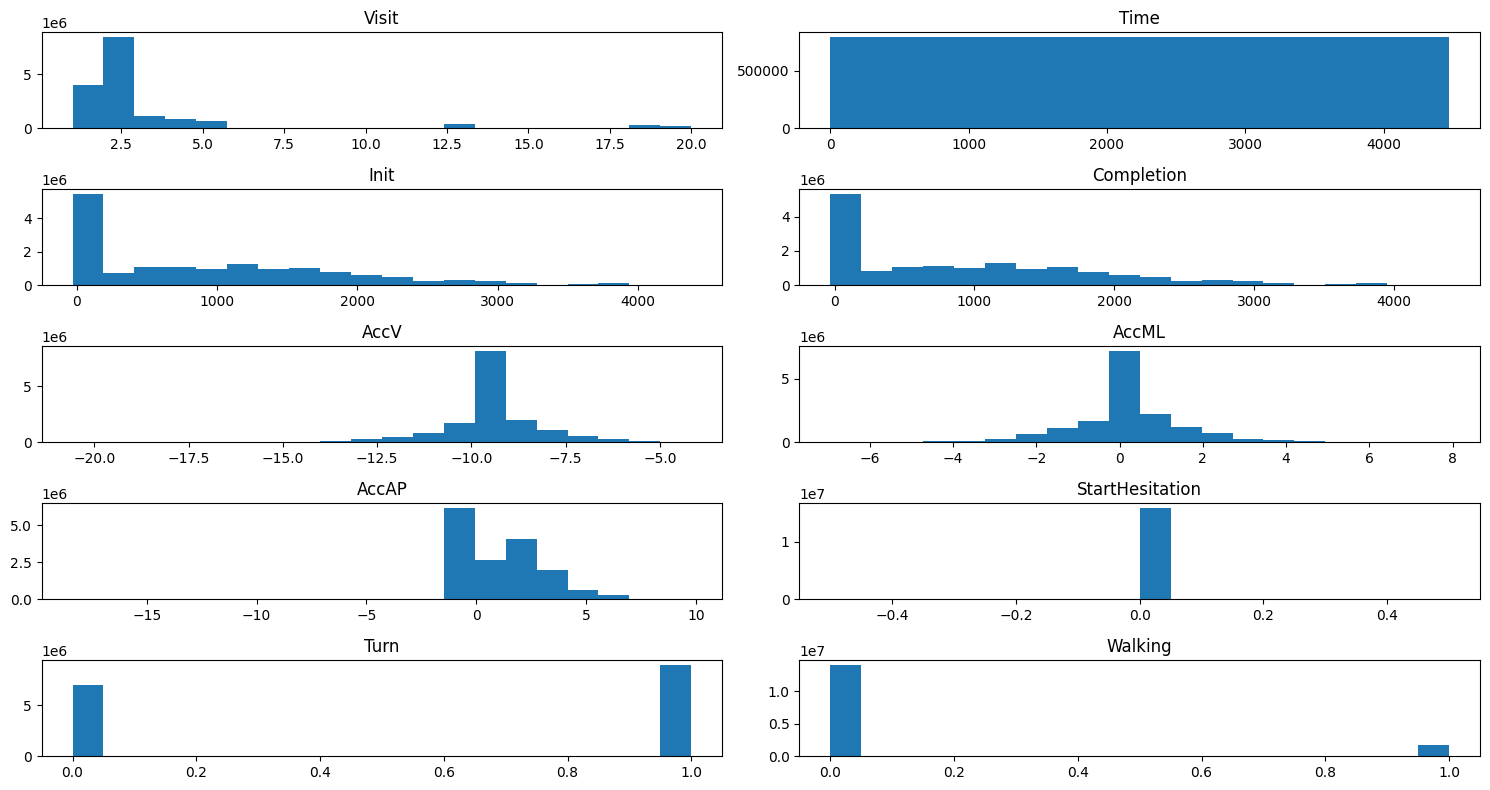

In [23]:
fig, axs = plt.subplots(5, 2, figsize=(15, 8))
axs = axs.flatten()

for i, col in enumerate(['Visit', 'Time','Init','Completion','AccV', 'AccML', 'AccAP', 'StartHesitation', 'Turn', 'Walking']):
    axs[i].hist(merged_df[col], bins=20)
    axs[i].set_title(col)
plt.tight_layout()
plt.show()

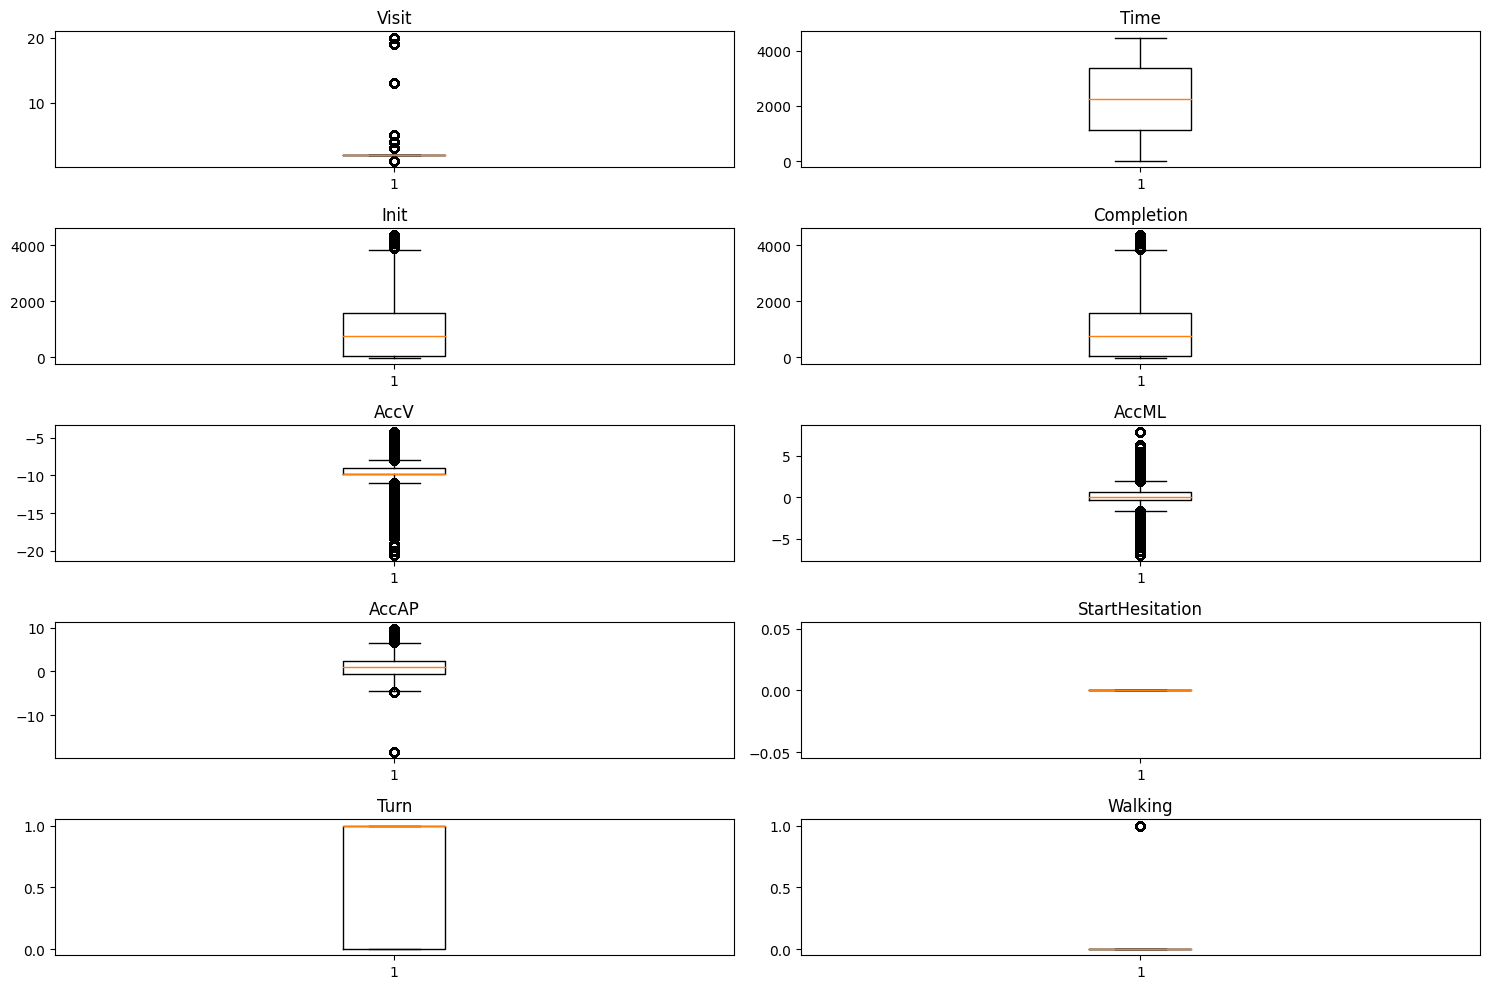

In [24]:
fig, axs = plt.subplots(5,2, figsize=(15, 10))
axs = axs.flatten()

for i, col in enumerate(['Visit', 'Time','Init','Completion','AccV', 'AccML', 'AccAP', 'StartHesitation', 'Turn', 'Walking']):
    axs[i].boxplot(merged_df[col])
    axs[i].set_title(col)
plt.tight_layout()
plt.show()

## Accelerometer Time Series Analysis for Fade Detection


Accelerometers in modern devices are used to measure acceleration and change in speed. In the context of this task, accelerations in the x, y, and z directions can provide some information about human behavior, including the presence of episodes of freezing, hesitation in turning or moving, delays in movement, etc.

The direction of acceleration along the x-axis (AccML) can reflect a change in the direction of movement of a person in the ground plane (for example, when turning), the direction of acceleration along the y-axis (AccAP) can reflect vertical movement (for example, going up or down stairs), and the direction of acceleration along z-axis (AccV) can reflect a change in forward or reverse speed.

In scoring validation, scoring values ​​can help identify episodes of stalling and hesitation in turning or scoring, for example, by analyzing the length of low score periods (or observed scoring variation) and scoring them against the overall length of the test run. Also, measurement values ​​can help determine the change in motion, for example, by measuring the mean or standard deviation of measurements along each of the axes.

The obtained features were used to build a model that can classify different motion episodes with high probability.

<AxesSubplot: >

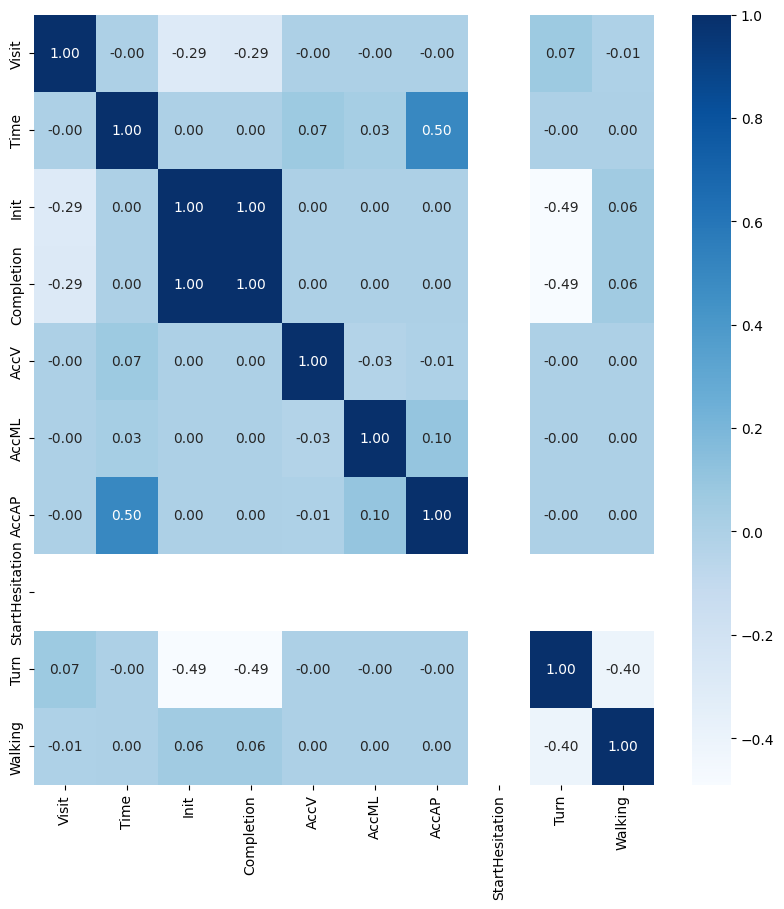

In [25]:
# Select the desired columns

columns = ['Visit','Time','Init','Completion','AccV', 'AccML', 'AccAP','StartHesitation','Turn', 'Walking']

# Create a new DataFrame containing only the selected columns

df_selected = merged_df[columns]

# Calculate the correlation matrix

corr_matrix = df_selected.corr()

# Visualize the correlation matrix with heatmap

fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt='.2f')

For plotting time series graphs of AccV, AccML and AccAP accelerometer values, I used the Time column because it is a time scale containing information about the time for which the measurements were taken.

The Init and Completion columns indicate the start and end of a fade (FOG) episode, respectively. If we use these columns to plot the time series, then we will only see the time intervals when the fading episodes occurred, not the full time series.

Therefore, to plot time series graphs based on accelerometer values ​​AccV, AccML and AccAP, it was logical to use the Time column, since it contains information about the time interval in which the accelerometer measurements were taken.

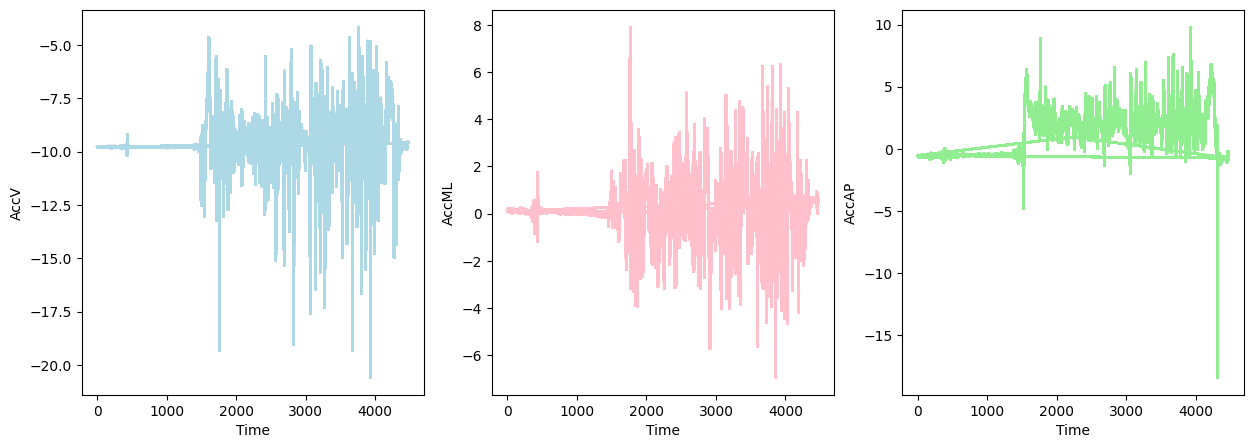

In [26]:
plt.rcParams['agg.path.chunksize'] = 200

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.plot(df_selected['Time'], df_selected['AccV'], color='lightblue')
plt.xlabel('Time')
plt.ylabel('AccV')

plt.subplot(132)
plt.plot(df_selected['Time'], df_selected['AccML'],color='pink')
plt.xlabel('Time')
plt.ylabel('AccML')

plt.subplot(133)
plt.plot(df_selected['Time'], df_selected['AccAP'],color='lightgreen')
plt.xlabel('Time')
plt.ylabel('AccAP')

plt.show()

* Sudden up or down jerks may indicate sudden changes in acceleration in the direction corresponding to the corresponding accelerometer column (eg AccV, AccML, AccAP). For example, a sharp drop down in the AccV chart could mean a sharp slowdown in the vertical direction.

* Sharp horizontal tapers can indicate the start or end of fade episodes or other motion uncertainty events such as starting uncertainty or movement delays. For example, a sharp branch in the AccV graph may indicate the onset of an episode of starting uncertainty when the person is unable to start walking.


* Other factors may also affect the shape and values ​​of the accelerometer time series, such as vibration, noise, and measurement errors. Therefore, before interpreting the graphs, it is necessary to make sure that the measurements are correct and accurate, and also take into account the context and features of a particular data set.

## Parse duration of FOG event types

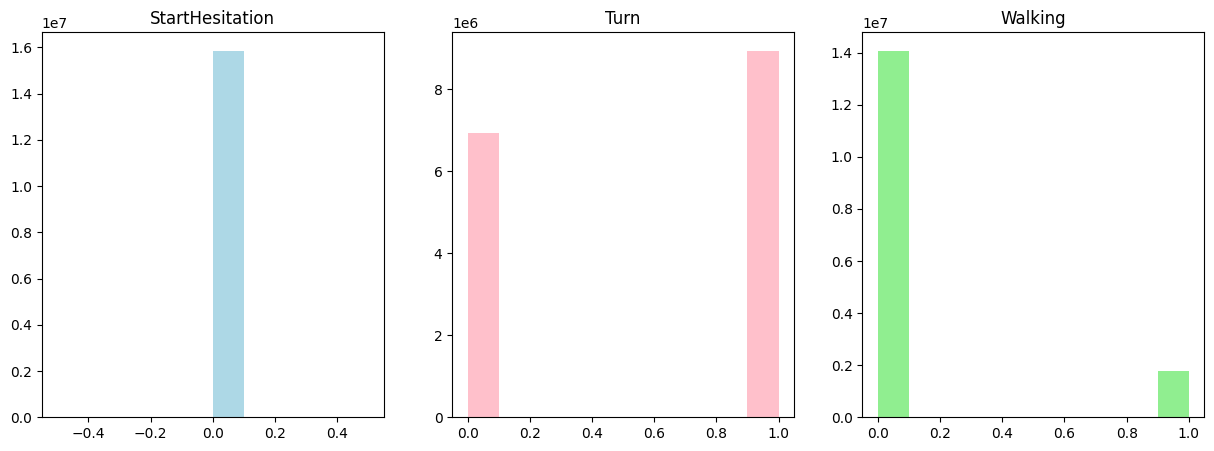

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].hist(df_selected['StartHesitation'], color='lightblue')
ax[0].set_title('StartHesitation')

ax[1].hist(df_selected['Turn'], color='pink')
ax[1].set_title('Turn')

ax[2].hist(df_selected['Walking'], color='lightgreen')
ax[2].set_title('Walking')

plt.show()

In [28]:
# Select only the Init and Completion columns for each type of event

start_hesitation_df = merged_df[['Init', 'Completion', 'StartHesitation']]
turn_df = merged_df[['Init', 'Completion', 'Turn']]
walking_df = merged_df[['Init', 'Completion', 'Walking']]

In [29]:
# Calculate the duration of each event

start_hesitation_df = start_hesitation_df.assign(Duration=start_hesitation_df['Completion'] - start_hesitation_df['Init'])
turn_df = turn_df.assign(Duration=turn_df['Completion'] - turn_df['Init'])
walking_df = walking_df.assign(Duration=walking_df['Completion'] - walking_df['Init'])

In [30]:
print("Start Hesitation Event Duration:")
print(start_hesitation_df['Duration'].describe())

print("\nTurn Event Duration:")
print(turn_df['Duration'].describe())

print("\nWalking Event Duration:")
print(walking_df['Duration'].describe())

Start Hesitation Event Duration:
count   15856291.000
mean           8.191
std           24.203
min            0.119
25%            1.210
50%            2.680
75%            6.920
max          581.980
Name: Duration, dtype: float64

Turn Event Duration:
count   15856291.000
mean           8.191
std           24.203
min            0.119
25%            1.210
50%            2.680
75%            6.920
max          581.980
Name: Duration, dtype: float64

Walking Event Duration:
count   15856291.000
mean           8.191
std           24.203
min            0.119
25%            1.210
50%            2.680
75%            6.920
max          581.980
Name: Duration, dtype: float64


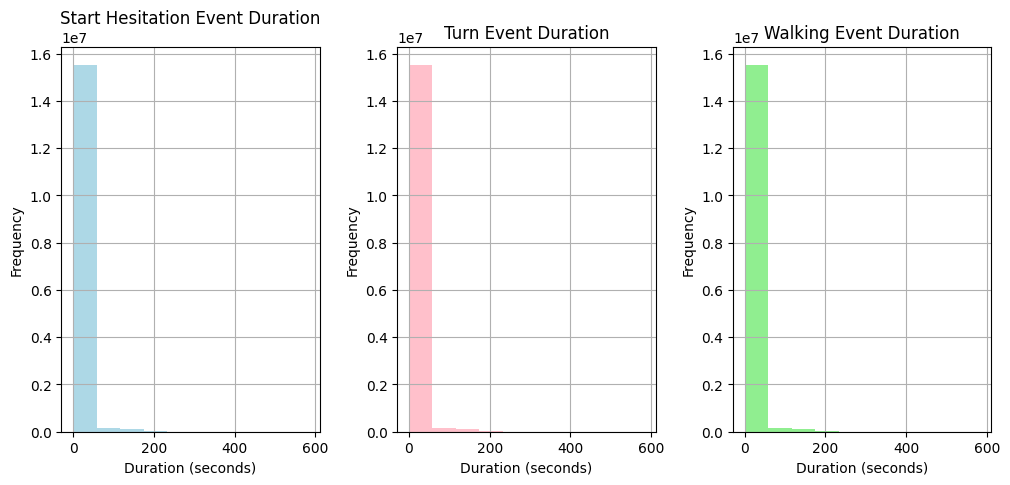

In [31]:
# Build duration histograms for each type of event

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,5))
start_hesitation_df.hist(column='Duration', ax=axes[0], color='lightblue')
turn_df.hist(column='Duration', ax=axes[1], color='pink')
walking_df.hist(column='Duration', ax=axes[2], color='lightgreen')

# Add titles and axis labels for each histogram

axes[0].set_title('Start Hesitation Event Duration')
axes[0].set_xlabel('Duration (seconds)')
axes[0].set_ylabel('Frequency')
axes[1].set_title('Turn Event Duration')
axes[1].set_xlabel('Duration (seconds)')
axes[1].set_ylabel('Frequency')
axes[2].set_title('Walking Event Duration')
axes[2].set_xlabel('Duration (seconds)')
axes[2].set_ylabel('Frequency')

plt.show()

Based on the descriptive statistics provided, it can be concluded that the average duration and standard deviation for each type of event (Start Hesitation, Turn, Walking) are the same. In addition, the minimum and maximum values ​​are also the same for all three types of events.

From these statistics, no conclusion can be drawn about the differences in duration between types of events. Perhaps the problem is in the distribution of the data itself or in the method of sampling.

In [32]:
merged_df.to_csv('EDA_Parkinson.csv', index=False)